In [2]:
import os
import cv2
import string
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix

from keras.optimizers import Adam, SGD
import datetime

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Símbolos presentes nos captchas
symbols = string.ascii_uppercase + "0123456789"
num_symbols = len(symbols)

print('Símbolos: ' + symbols)
print('Quantidade de símbolos: ' + str(num_symbols))

# Tamanho das imagens de entrada à RN
img_height = 30
img_width = 80
img_shape = (img_height, img_width, 1)

# Tamanho da palavra no captcha
size_word = 5

Símbolos: ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Quantidade de símbolos: 36


In [4]:
################################################################################################################
#
# Leitura dos nomes dos arquivos
#
#    Realiza a leitura do nome dos arquivos de captchas recebendo por parametro o diretório onde os arquivos 
#    estão armazenados.
#    Retorna a lista do nome de arquivos.
#
################################################################################################################

def read_name_files(files_dir = 'dataset'):

    files = os.listdir(files_dir)
    
    return files

In [5]:
################################################################################################################
#
# Leitura das imagens em lote
#
#    Realiza a leitura das imagens captchas recebendo por parametro os símbolos que formam os captchas,
#    a lista dos nomes dos arquivos e o diretório onde os arquivos estão armazenados.
#    Retorna o dataset no formato X e y.
#
################################################################################################################

def read_dataset_batch(symbols, batch_files, captcha_dir = 'dataset'):
    
    n_samples = len(batch_files)
    
    X = np.zeros((n_samples, img_height, img_width, 1))
    y = np.zeros((size_word, n_samples, num_symbols))

    i = 0;
    
    # Leitura de cada arquivo
    for name_file in batch_files:
        
        img = cv2.imread(os.path.join(captcha_dir, name_file), cv2.IMREAD_GRAYSCALE)
        word = name_file[:-4] # retira a extensão .png
        
        # Se a palavra tem 5 caracteres
        if len(word) == size_word:
            
            img = img / 255. # Coloca o valor dos pixels entre 0 e 1
            
            # Faz o reshape da imagem para a metade do tamanho da altura e comprimento, reduzindo ela em 1/4 do tamanho
            img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            
            # Matriz alvo, possui numero da caracteres na palavra por número de caracteres possíveis
            # Na matriz alvo se a posição corresponde a determinado símbolo o valor da célula será 1, 
            # e 0 caso contrário.
            targs = np.zeros((size_word, num_symbols))
            
            for idx_letter, simbol in enumerate(word):
                n_simbol = symbols.find(simbol)
                targs[idx_letter, n_simbol] = 1
                
            X[i] = img
            y[:, i] = targs
            
            i = i +1;
            
            # Controle de progresso
            if(i%10000 == 0):
                print(str(i) + " imagens read");

    return X, y

In [139]:

name_dir_test = 'dataset_test';
name_captcha_files_test = read_name_files(files_dir = name_dir_test)
print('Número de imagens no dataset teste: ' + str(len(name_captcha_files_test)))

X_test, y_test = read_dataset_batch(symbols, name_captcha_files_test, captcha_dir = name_dir_test)

Número de imagens no dataset teste: 19976
10000 imagens read


In [7]:
#Epoch 00057: early stopping
#[I 2020-08-01 19:20:48,090] Trial 1 finished with value: 1.8565971174443183 and parameters: {'num_cnn_blocks': 5, 'num_filters': 64, 'kernel_size': 3, 'num_dense_nodes': 512, 'batch_size': 32, 'lr': 0.0005830814356977948, 'b1': 0.010365629228217594, 'b2': 0.08919912494637089}. Best is trial 1 with value: 1.8565971174443183.

In [34]:
def create_model(dict_params):     

    img = layers.Input(shape=img_shape)
    x=img
    for iblock in range(dict_params['num_cnn_blocks'] - 1):
        x = layers.Conv2D(filters=dict_params['num_filters'],kernel_size=dict_params['kernel_size'], strides=1, padding='same',name=f"c{iblock}")(x) # 25 100 48   
        x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid',name=f"p{iblock}")(x)

    flatten = layers.Flatten(name="flatten")(x)
    outs = []
    out = layers.Dense(dict_params['num_dense_nodes'], activation='relu')(flatten)
    for _ in range(5):
        res = layers.Dense(36, activation='softmax')(out)
        outs.append(res)
    model = Model(img, outs)
    #opt = optimizers.SGD(lr=0.001, momentum=0.9)

    model.compile(optimizer=Adam(lr=dict_params['lr'],beta_1=dict_params['b1'],beta_2=dict_params['b2']), loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],metrics=['accuracy'])
    model.summary()
    return model

In [37]:
# Create a new model instance
dict_params = {'num_cnn_blocks':5,
                'num_filters':64,
                'kernel_size':3,
                'lr':0.0005830814356977948,
               'num_dense_nodes':512,
               'lr': 0.0005830814356977948, 
               'b1': 0.010365629228217594, 
               'b2': 0.08919912494637089
              }
model = create_model(dict_params)

# Load the previously saved weights
model.load_weights('train-val-0.8-1.7.hdf5')

# Re-evaluate the model
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 30, 80, 1)    0                                            
__________________________________________________________________________________________________
c0 (Conv2D)                     (None, 30, 80, 64)   640         input_20[0][0]                   
__________________________________________________________________________________________________
p0 (MaxPooling2D)               (None, 15, 40, 64)   0           c0[0][0]                         
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 15, 40, 64)   36928       p0[0][0]                         
___________________________________________________________________________________________

[1.8174037803971486,
 0.20301446318626404,
 0.43772226572036743,
 0.5227359533309937,
 0.44969725608825684,
 0.20439255237579346,
 0.9364237189292908,
 0.8698938488960266,
 0.8472667336463928,
 0.8679415583610535,
 0.9330196380615234]

In [38]:

################################################################################################################
#
# Predição
#
#    Função que recebe um modelo e uma imagem captcha e retorna a string contida nela conforme determinado pelo
#    modelo.
#
################################################################################################################

def predict(net, img):
    
    word_predicted = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    word_predicted = np.reshape(word_predicted, (size_word, num_symbols))
    
    capt = ''
    for symbol in word_predicted:
        idx_symbol = np.argmax(symbol)
        capt += symbols[idx_symbol]
    
    return capt

In [39]:

################################################################################################################
#
# Plota Matriz de Confusão
#
#    Plota a Matriz de confunsão das classes reais vs as preditas
#
################################################################################################################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        
    #print(cm)

    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)    
    plt.yticks(tick_marks, classes)

    plt.tick_params(axis='both', which='major')
    plt.tick_params(axis='both', which='minor')
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [40]:
################################################################################################################
#
# Métricas
#
#    Plota a Matriz de confunsão e retorna as métricas de acurácia.
#
################################################################################################################

def metrics(x, y, model):
    
    # Estatísticas
    # index 5 = matriz total, de todos os digitos.
    confusion_digit_predict = [[] for _ in range(6)]
    confusion_digit_true = [[] for _ in range(6)]

    y_d = np.array(y)    
    y_d = np.argmax(y, axis=2);    
    d_num_correct = [0, 0, 0, 0, 0]
    #print(x.shape);
    #print(x[0].shape);
    for i in range(x.shape[0]):
        capt = predict(model, x[i,:,:,0])        
        
        for j in range(size_word):
            d_num_correct[j] = d_num_correct[j] + np.sum(capt[j] == symbols[y_d[j][i]])
            confusion_digit_predict[j].extend(capt[j]);
            confusion_digit_true[j].extend(symbols[y_d[j][i]]);
            #Geral
            confusion_digit_predict[5].extend(capt[j]);
            confusion_digit_true[5].extend(symbols[y_d[j][i]]);
    
    # Plota matizes de confusion:
    for j in range(size_word):
        plot_confusion_matrix(confusion_matrix(confusion_digit_predict[j], confusion_digit_true[j]), symbols, title='Confusion matrix D'+str(j))
    
    # Matrix geral
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[5], confusion_digit_true[5]), symbols, title='Confusion matrix Geral')
    
    num_samples = x.shape[0];
    num_caracteres = len(capt)*num_samples;
    num_correct = np.sum(d_num_correct);
    
    d_accuracy = np.array(d_num_correct)/num_samples
    accuracy = float(num_correct)/num_caracteres
    
    #plot_confusion_matrix(confusion_matrix(true_class, predicted_class), className)
    
    return accuracy, d_accuracy

In [41]:
################################################################################################################
#
# Amostras de Predição
#
################################################################################################################
def predict_sample(net):
    
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    
    j = 0
    k = 0
    for i in (10, 100, 1000, 10000):        
        img = X_test[i,:,:]
        img.shape = (30,80)    
        axs[j%2][k%3].imshow(img, cmap='gray')
        
        word = predict(net,img)
        axs[j%2][k%2].set_title(word)
        
        k = (j - 1 < 1)
        j = j + 1
    
    plt.axis('off')    

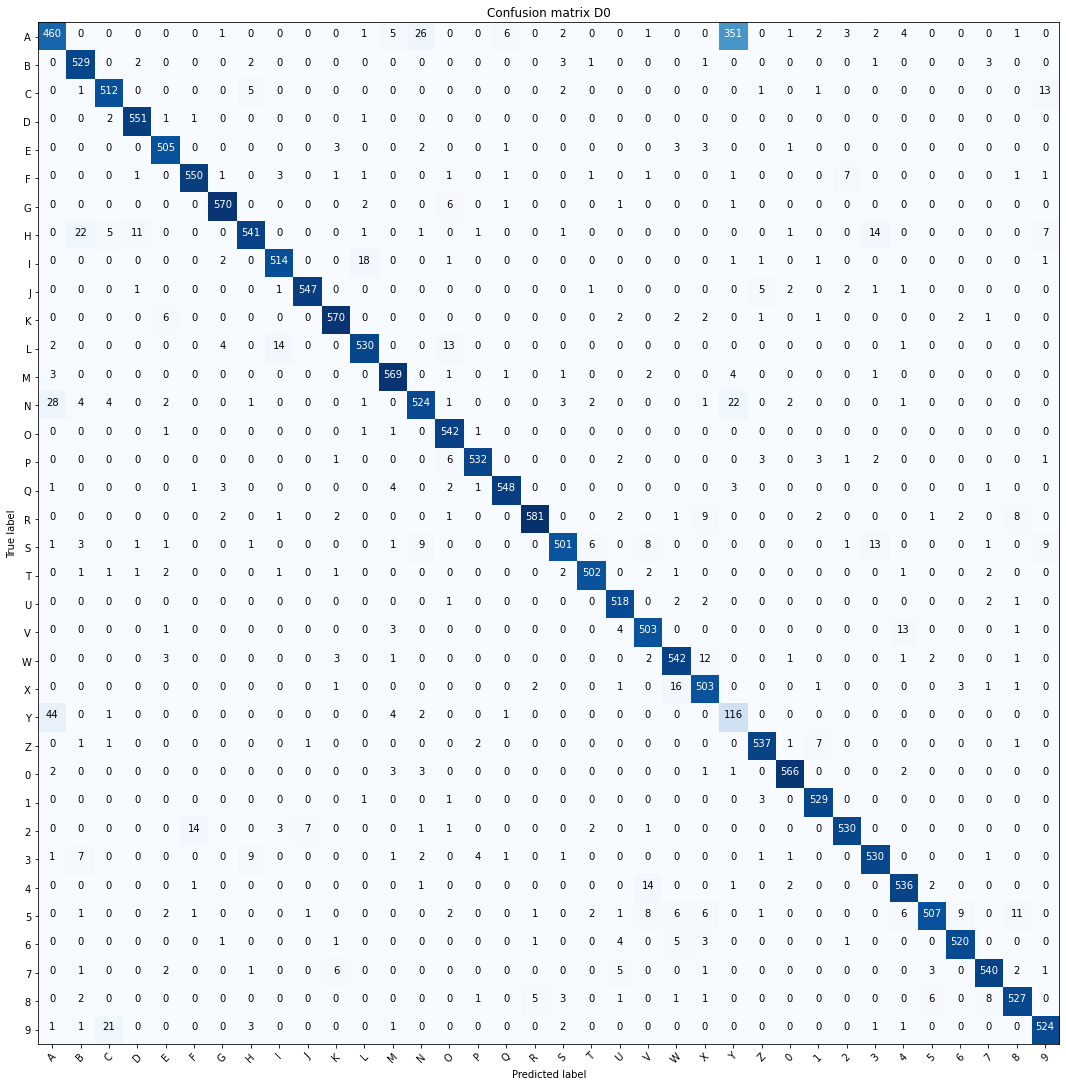

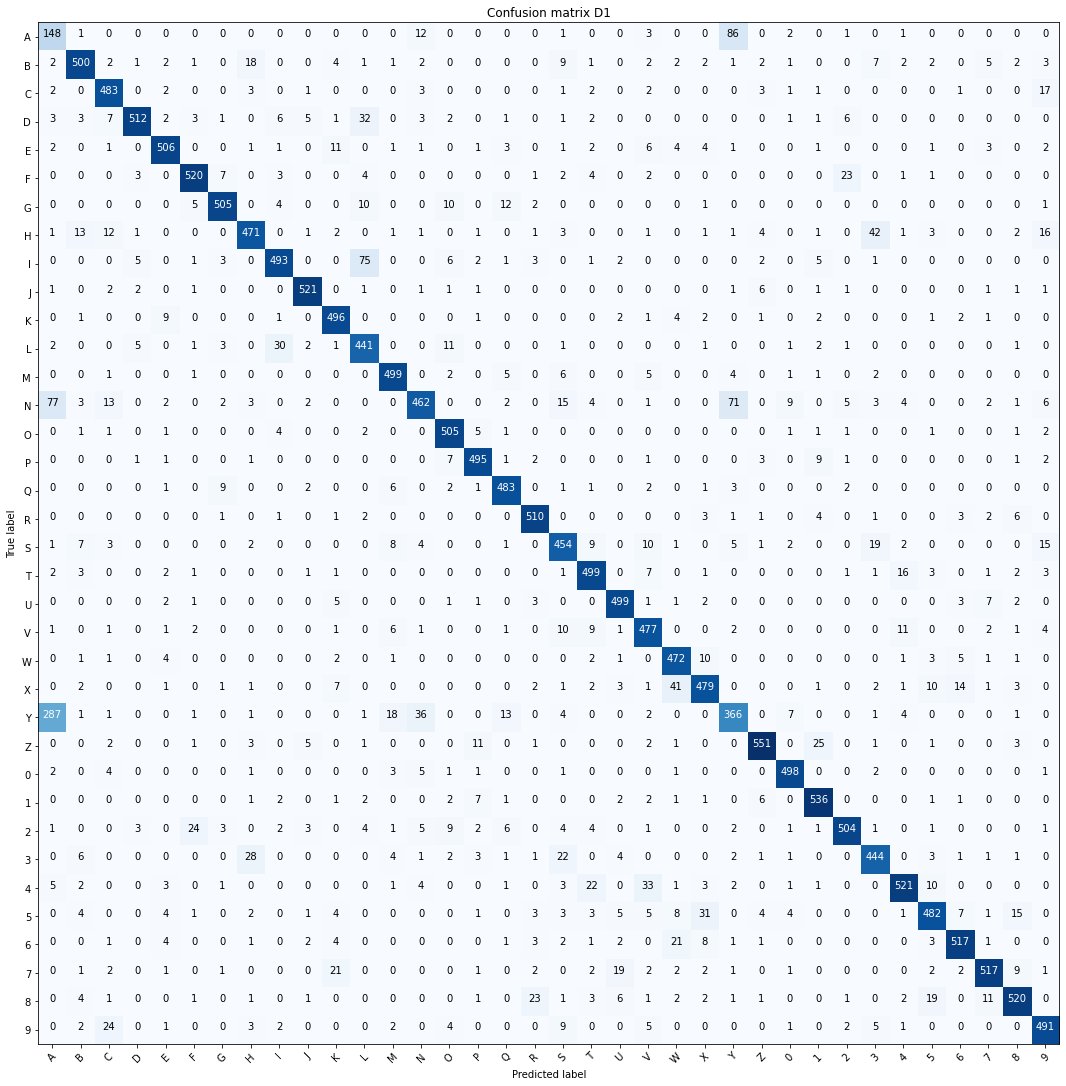

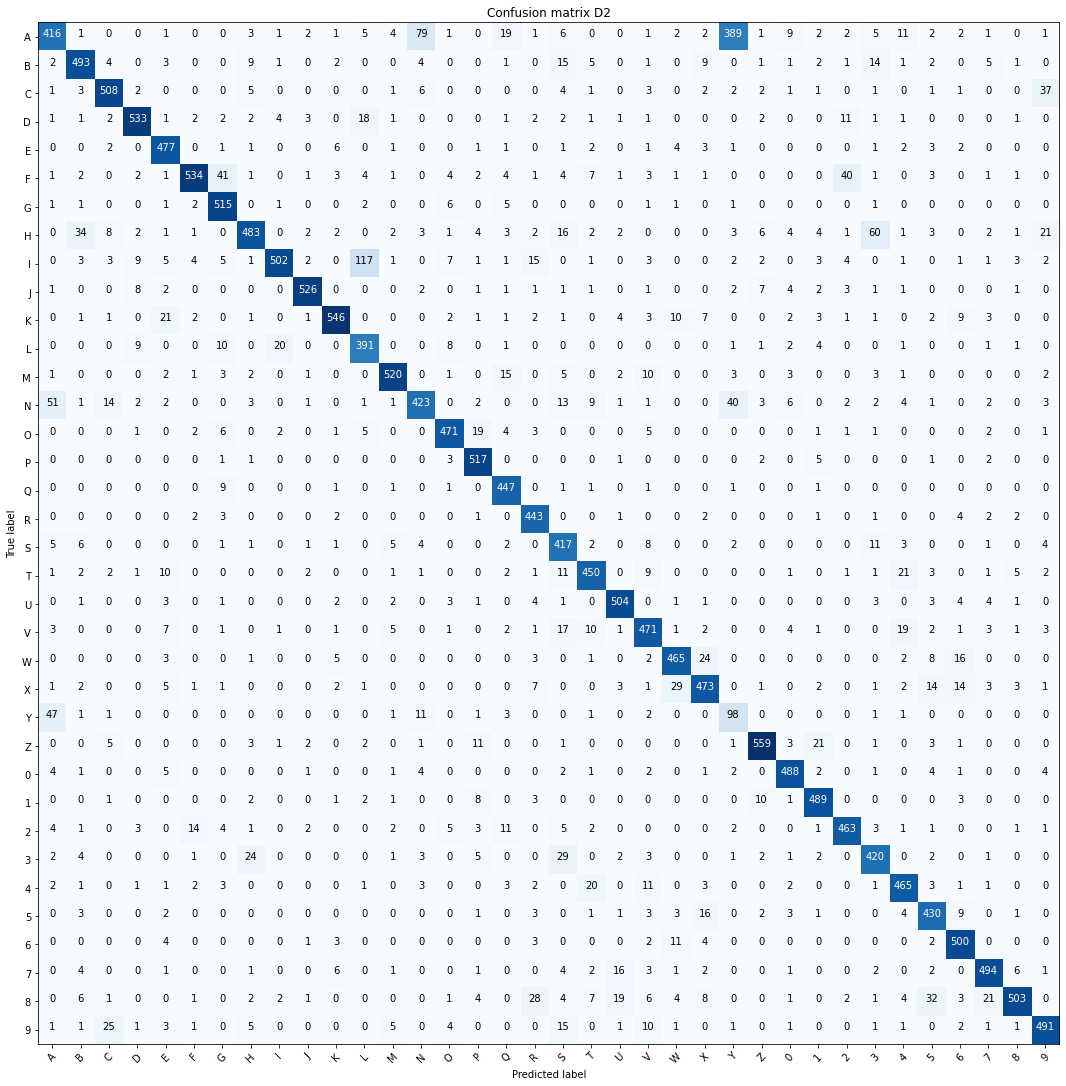

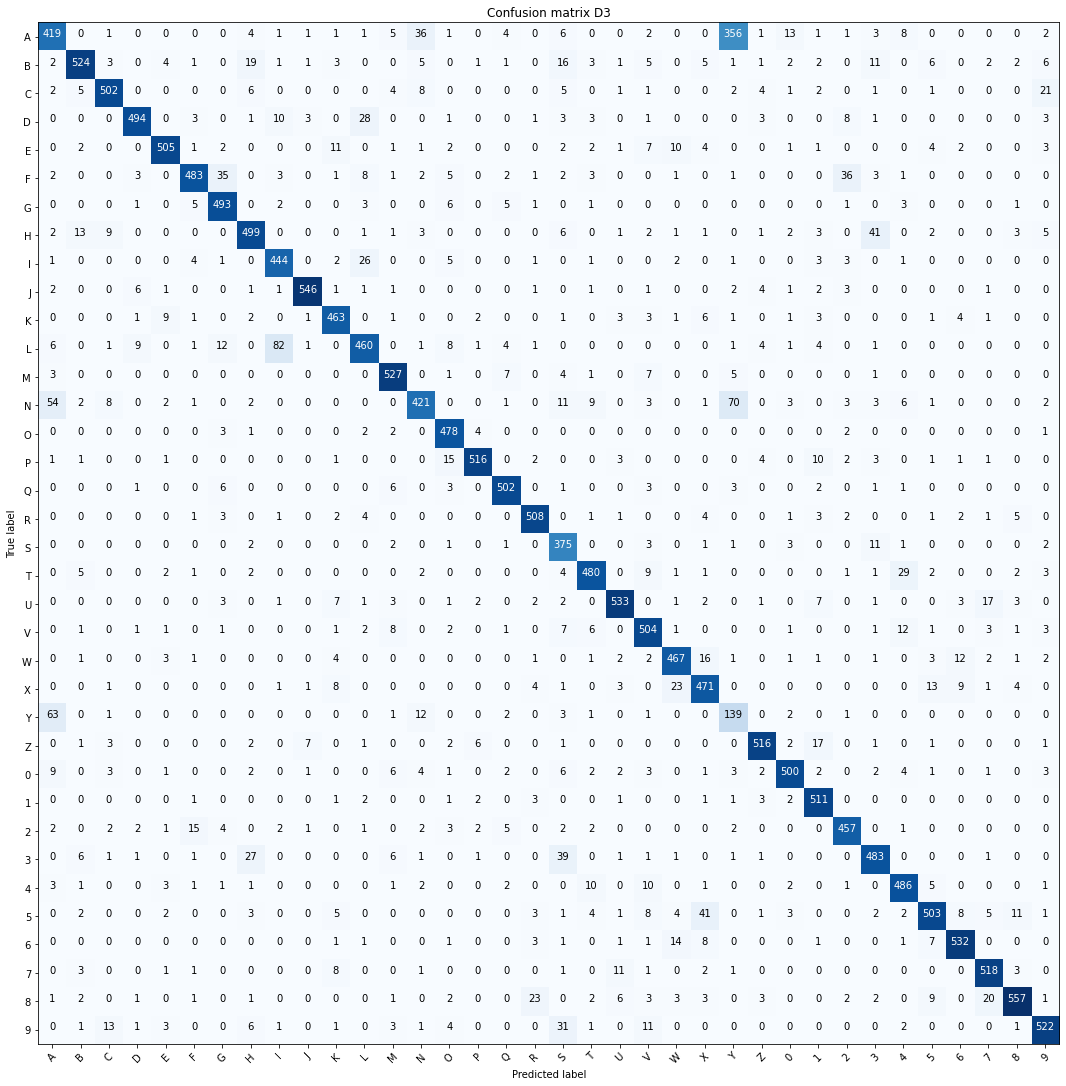

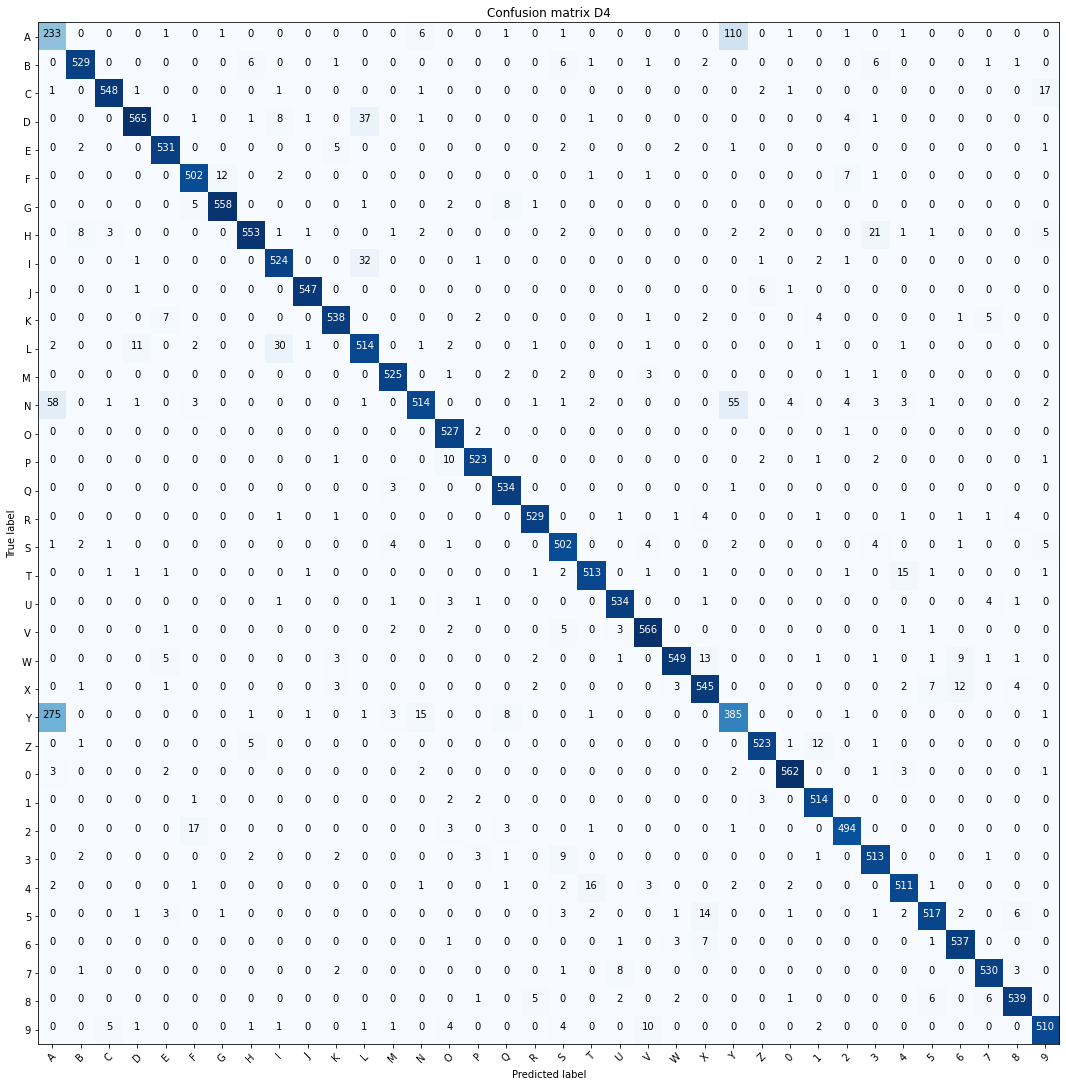

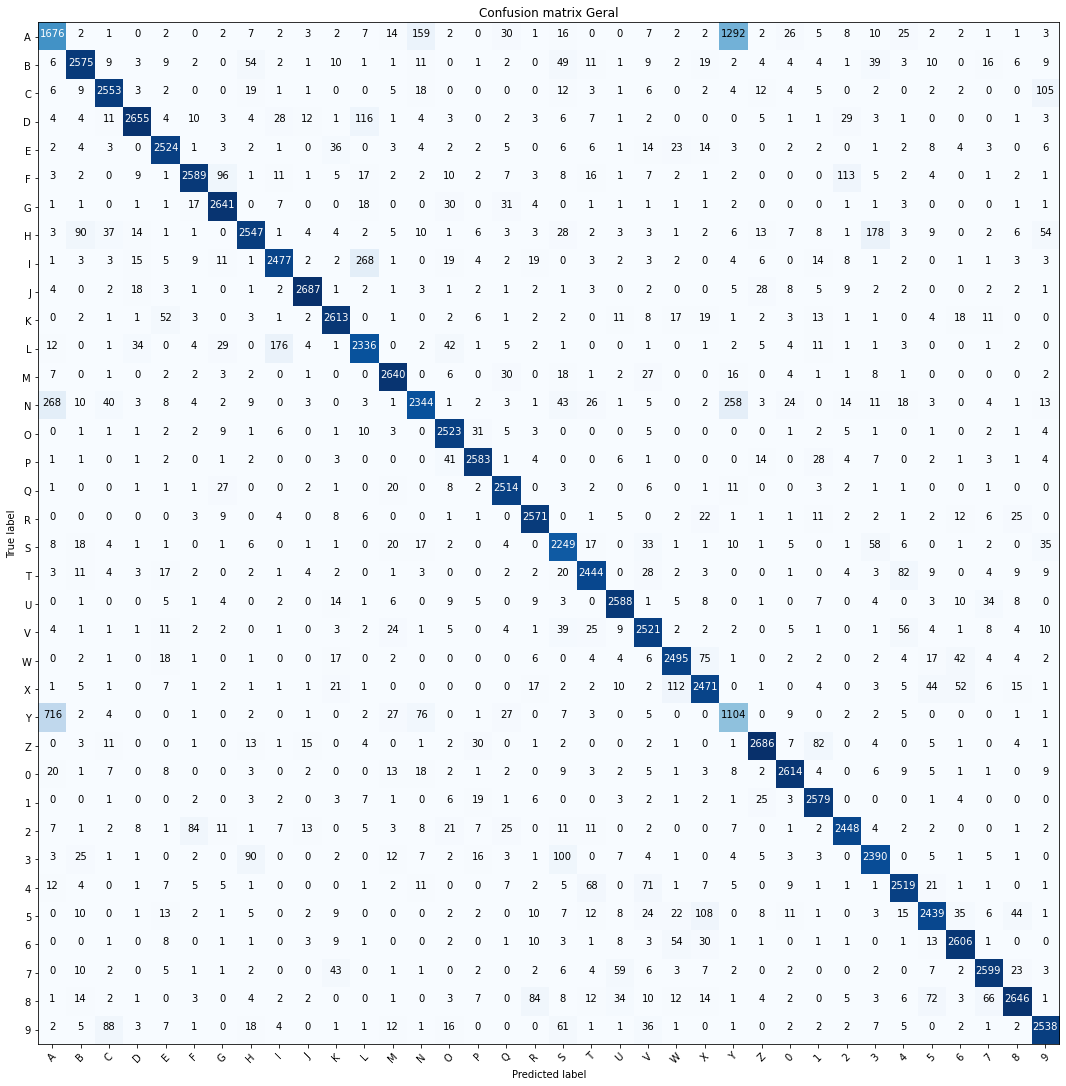

In [42]:
accuracy, d_accuracy = metrics(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], model)

In [43]:
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%(accuracy, d_accuracy[0], d_accuracy[1], d_accuracy[2], d_accuracy[3], d_accuracy[4]))

Accuracy on test data is: 0.89, acc_d1= 0.94, acc_d2= 0.87, acc_d3= 0.85, acc_d4= 0.87, acc_d5= 0.93


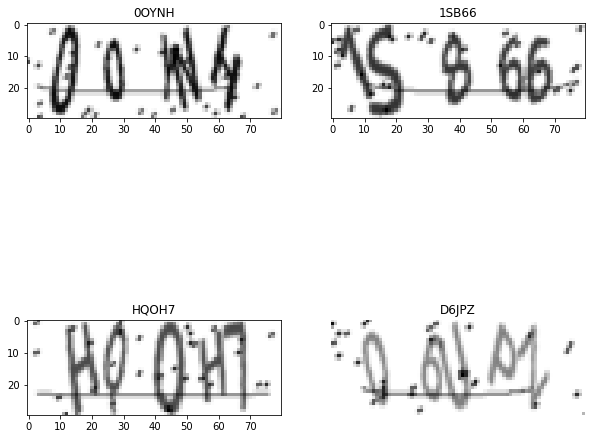

In [45]:
# Exemplo de predição
predict_sample(model);

In [198]:
# Saída por camada
# Get Output Layers
# MaxPool_1
#layer_name = 'MaxPool_1'

def plot_layers_output(model):
  layer_name = ['c0','c1','c2','c3']
  fig = plt.figure(figsize=(30,80))

  num_filtros = 5;
  idx_plot = 0
  for layer in layer_name:
      
      intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer).output)
      features = intermediate_output = intermediate_layer_model.predict(img[np.newaxis, :, :, ])
      num_filtros = features.shape[3]
      for i in range(num_filtros):
      
          ax = fig.add_subplot(64,8, idx_plot+1, xticks=[], yticks=[])   
          ax.set_title(layer + '_' + str(i))
          plt.imshow(features[0,:,:,i], cmap="gray")
          idx_plot = idx_plot + 1
      
  plt.show()

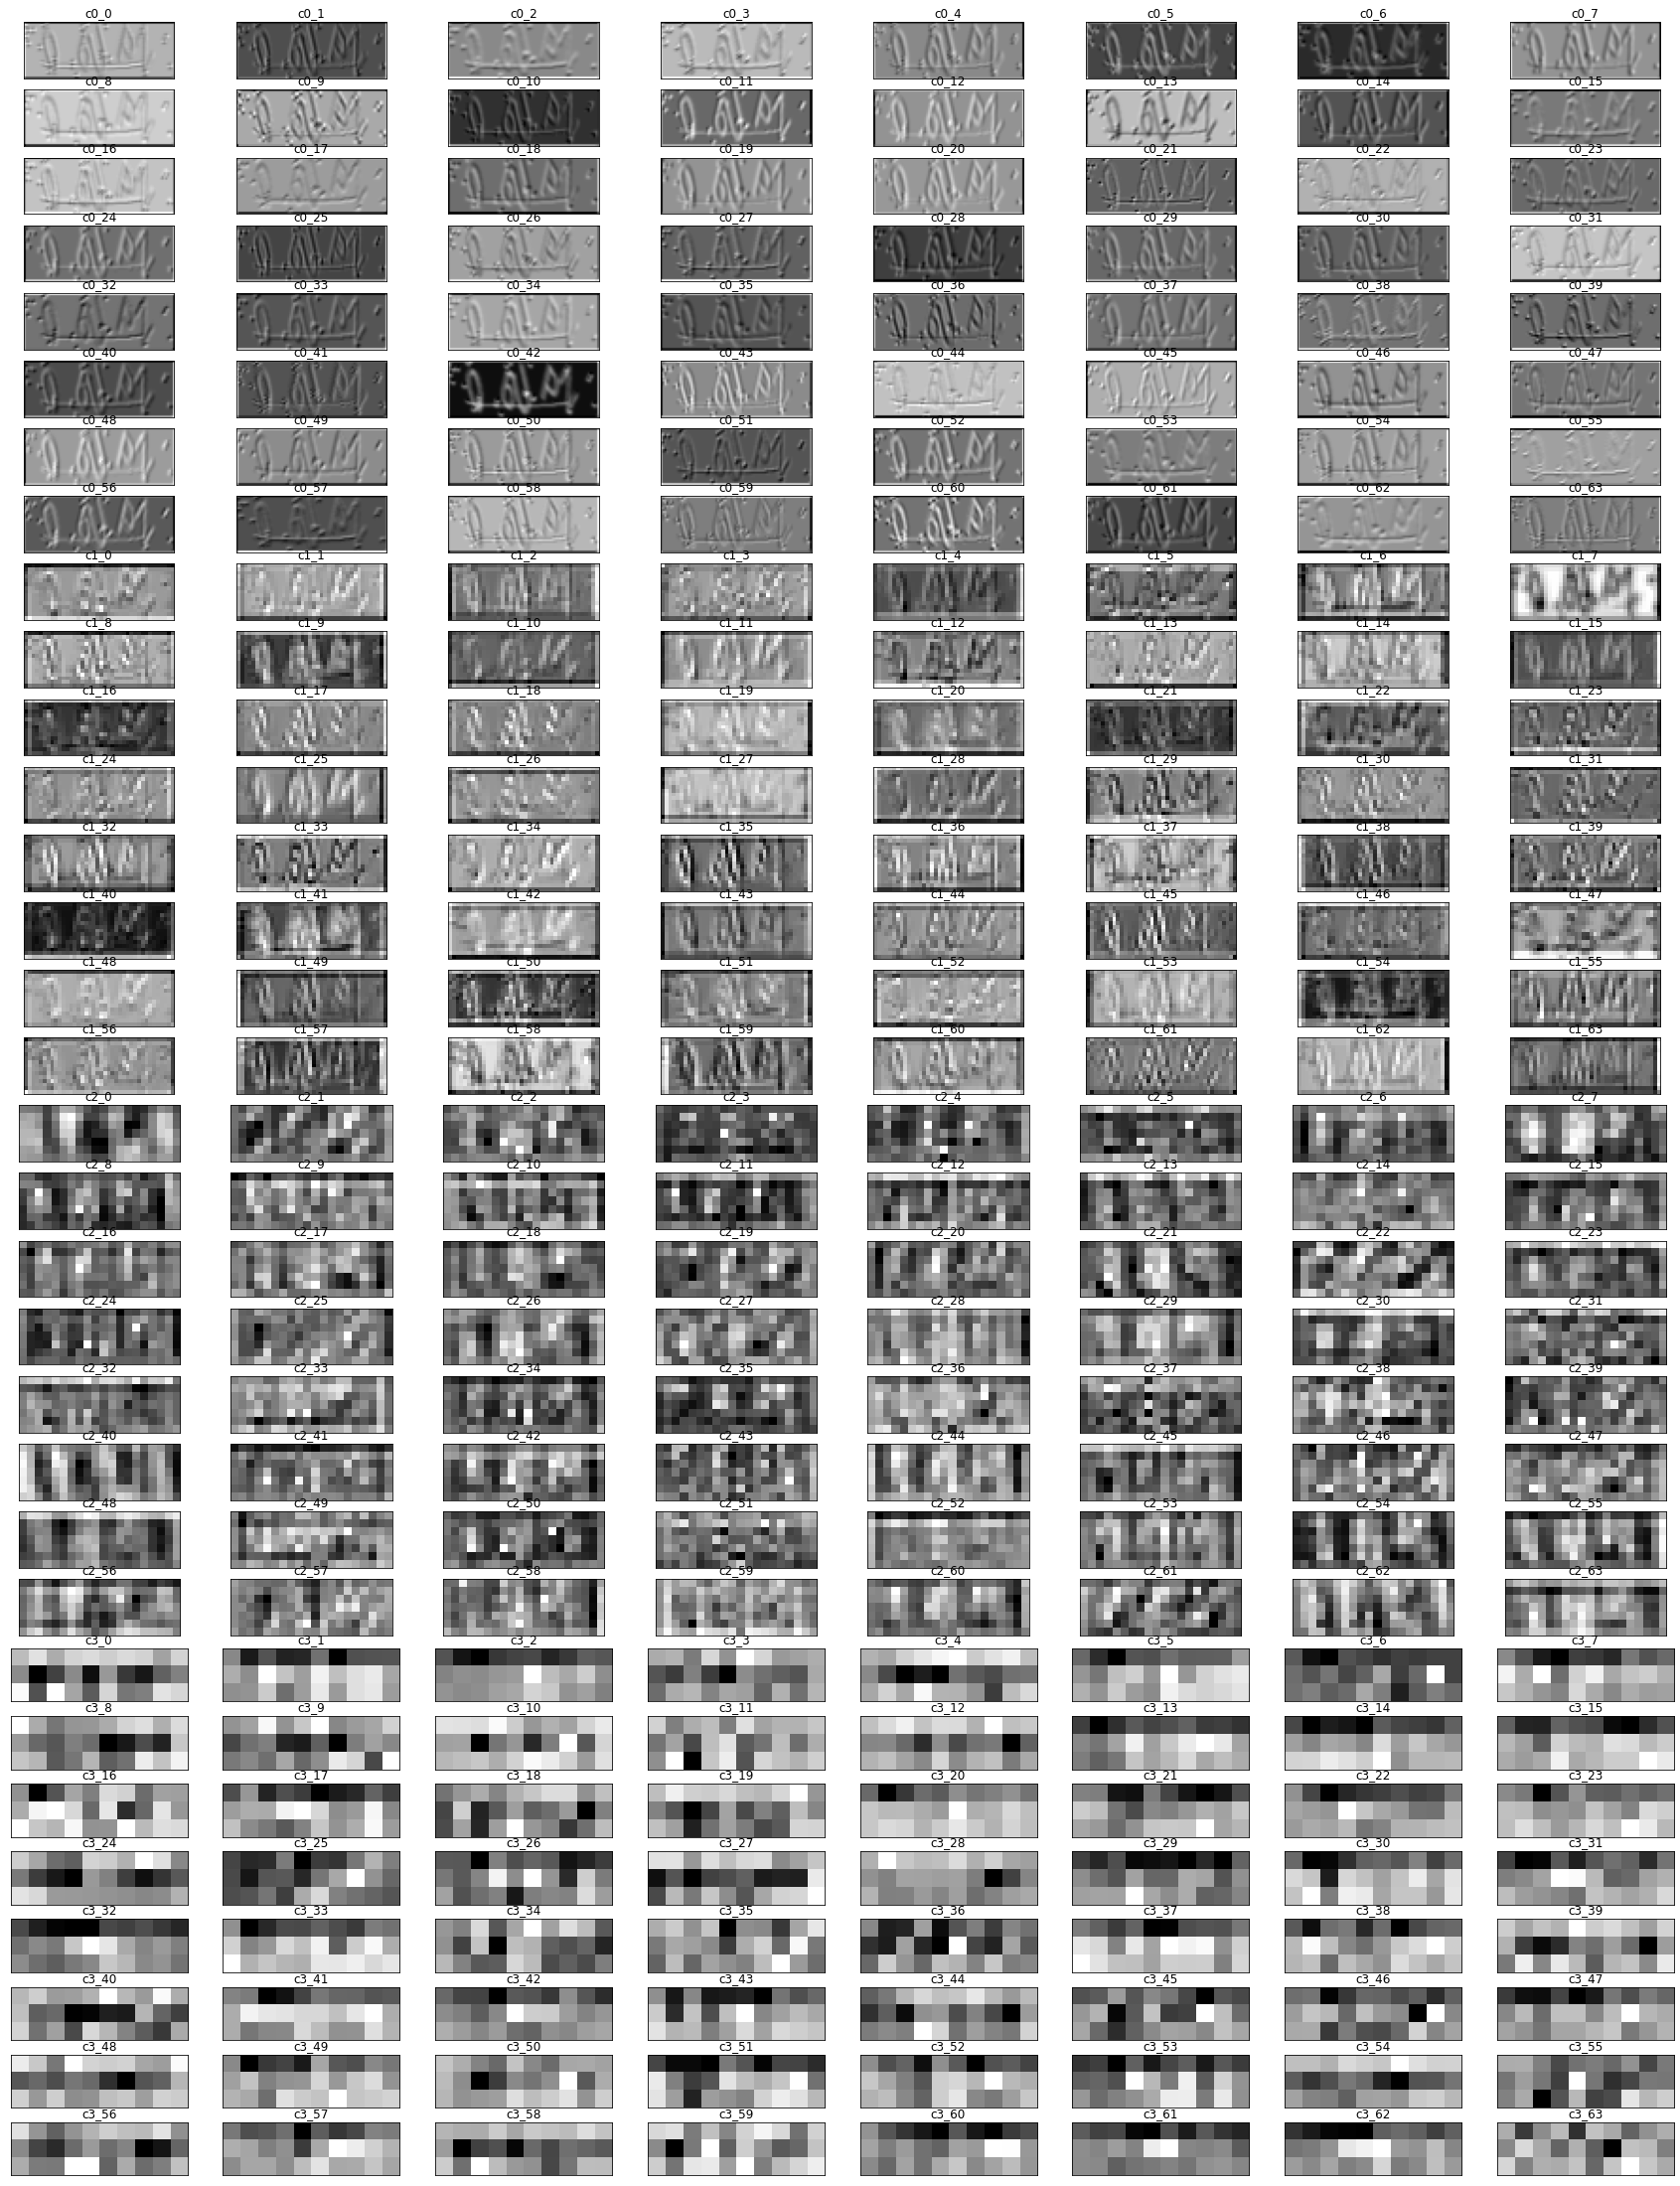

In [200]:
img = X_test[100,:,:].copy()

plot_layers_output(model)